In [1]:
# Load the Excel file
file_path = "All Data.xlsx"

=== Advanced Damage Forecast Program ===

Available countries: ['USA' 'JAM' 'JPN' 'TUR' 'IND' 'CPV' 'UGA' 'GTM' 'MMR' 'MTQ' 'VCT' 'SUN'
 'CHN' 'CAN' 'COM' 'ISR' 'IRN' 'NER' 'BGD' 'TWN' 'GRC' 'ITA' 'PHL' 'ALB'
 'COL' 'CHL' 'HKG' 'ROU' 'IDN' 'FRA' 'HTI' 'MAR' 'PRT' 'PAK' 'CRI' 'DZA'
 'BFA' 'GMB' 'GNB' 'MLI' 'MRT' 'SEN' 'TCD' 'KAZ' 'MEX' 'PER' 'TKL' 'PRI'
 'NZL' 'AIA' 'DFR' 'ARG' 'ECU' 'BHS' 'CUB' 'EGY' 'JOR' 'BGR' 'POL' 'GLP'
 'MSR' 'KNA' 'BEL' 'DOM' 'NIC' 'FJI' 'BLZ' 'HND' 'SLB' 'ARM' 'TTO' 'SLV'
 'NOR' 'KOR' 'PNG' 'NCL' 'GHA' 'AUS' 'VUT' 'SDN' 'ESP' 'YMN' 'COK' 'YUG'
 'LBY' 'TON' 'AZO' 'BMU' 'REU' 'BRA' 'ATG' 'VEN' 'CHE' 'GBR' 'ZAF' 'AUT'
 'NLD' 'VNM' 'CYP' 'IRQ' 'AFG' 'ANT' 'NPL' 'BRB' 'LBN' 'MOZ' 'MNG' 'LKA'
 'TUN' 'SPI' 'PYF' 'NIU' 'LCA' 'MUS' 'ETH' 'SOM' 'THA' 'GUM' 'DMA' 'GRD'
 'PRY' 'SAU' 'KEN' 'TZA' 'PAN' 'WSM' 'WLF' 'MYS' 'BOL' 'BWA' 'TGO' 'COD'
 'LAO' 'ASM' 'URY' 'MWI' 'SYR' 'COG' 'MDG' 'LSO' 'SUR' 'NGA' 'BEN' 'HUN'
 'CIV' 'GUY' 'CMR' 'KIR' 'TUV' 'YMD' 'ISL' 'CAF' 'CSK' 'RWA' 

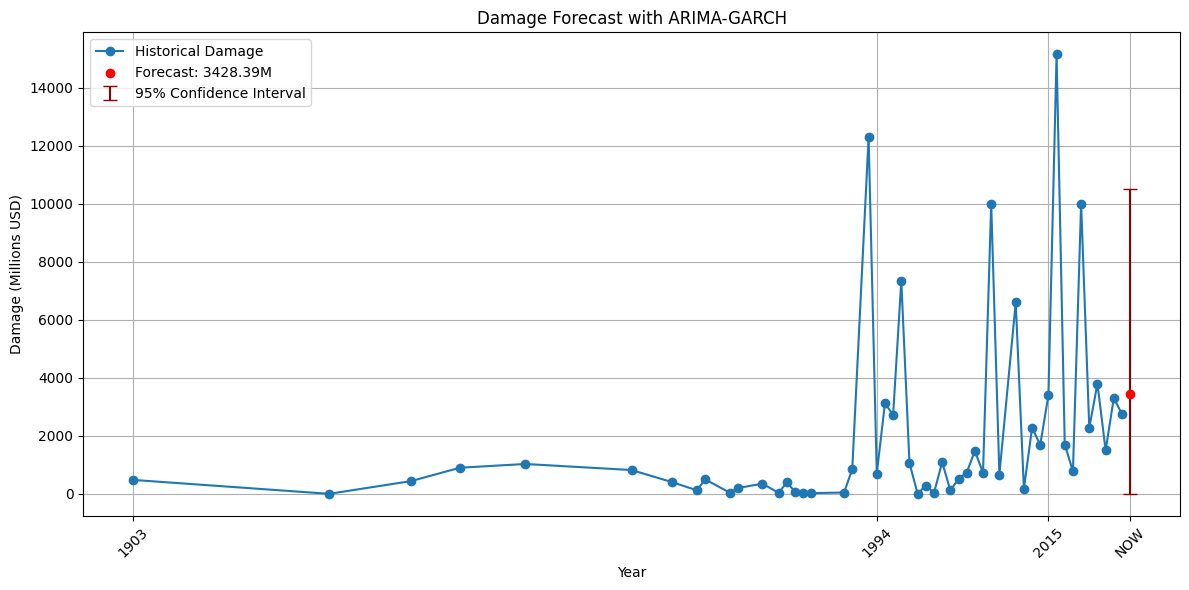

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
import warnings
import matplotlib.pyplot as plt

def load_data(file_path):
    try:
        return pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

def forecast_damage(data, country, disaster_type):
    # Filter and preprocess data
    filtered_data = data[(data['ISO'] == country.upper()) & 
                        (data['Disaster Type'] == disaster_type)].copy()
    
    if filtered_data.empty:
        return (f"No historical data available for {disaster_type} in {country}.", 
                None, None, None, None, None, None)

    # Extract year and convert damage values
    filtered_data['Year'] = filtered_data['DisNo.'].str[:4].astype(int)
    filtered_data['Total Damage (Millions)'] = filtered_data['Total Damage (\'000 US$)'] / 1_000
    historical_data = filtered_data[['Year', 'Total Damage (Millions)']].dropna().groupby('Year').sum()

    # Stationarity check
    adf_result = adfuller(historical_data['Total Damage (Millions)'].dropna())
    print("\nAugmented Dickey-Fuller Test Results:")
    print(f"ADF Statistic: {adf_result[0]:.3f}")
    print(f"p-value: {adf_result[1]:.3f}")

    # ARIMA Model Selection
    warnings.filterwarnings("ignore")
    best_aic, best_order, best_model = float("inf"), None, None
    
    for p in range(0, 3):
        for d in range(0, 2):
            for q in range(0, 3):
                try:
                    model = ARIMA(historical_data, order=(p, d, q))
                    fitted_model = model.fit()
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_order = (p, d, q)
                        best_model = fitted_model
                except:
                    continue

    if best_model is None:
        return ("ARIMA model fitting failed", 
                None, None, None, None, None, None)

    # GARCH Model on ARIMA residuals (selecting best GARCH order)
    residuals = best_model.resid.dropna()
    best_garch_aic, best_p, best_q = float("inf"), None, None
    
    for p in range(1, 3):  # Testing GARCH(1,1), GARCH(2,1), etc.
        for q in range(1, 3):  # Same for the MA component of GARCH
            try:
                garch = arch_model(residuals, vol='GARCH', p=p, q=q)
                garch_fit = garch.fit(disp='off')
                if garch_fit.aic < best_garch_aic:
                    best_garch_aic = garch_fit.aic
                    best_p, best_q = p, q
                    best_garch_model = garch_fit
            except Exception as e:
                continue

    if best_garch_aic == float("inf"):
        return ("GARCH model fitting failed", 
                None, None, None, None, None, None)

    # Print the best GARCH order
    print(f"\nBest GARCH model: GARCH({best_p}, {best_q})")

    # Forecast with ARIMA and GARCH
    arima_forecast = best_model.forecast(steps=1).iloc[0]
    garch_forecast = best_garch_model.forecast(horizon=1)
    conditional_vol = np.sqrt(garch_forecast.variance.iloc[-1,0])
    
    # Calculate prediction intervals with floor at 0
    upper_bound = arima_forecast + 1.96 * conditional_vol
    lower_bound = max(arima_forecast - 1.96 * conditional_vol, 0.0)

    return (round(arima_forecast, 2), 
            historical_data, 
            best_order, 
            round(best_aic, 2), 
            adf_result[1],
            round(lower_bound, 2), 
            round(upper_bound, 2))

def plot_forecast(historical_data, forecast, lower_bound, upper_bound):
    plt.figure(figsize=(12, 6))
    last_year = historical_data.index[-1]
    
    # Historical data
    plt.plot(historical_data.index, historical_data['Total Damage (Millions)'], 
            marker='o', label='Historical Damage')
    
    # Forecast point and CI
    plt.scatter(last_year+1, forecast, color='red', zorder=5,
               label=f'Forecast: {forecast}M')
    
    # Correct error bar format
    plt.errorbar(last_year+1, forecast,
                yerr=[[forecast - lower_bound], [upper_bound - forecast]],
                fmt='none', ecolor='darkred', capsize=5,
                label='95% Confidence Interval')
    
    plt.title("Damage Forecast with ARIMA-GARCH")
    plt.xlabel('Year')
    plt.ylabel('Damage (Millions USD)')
    plt.legend()
    plt.grid(True)
    
    # X-axis formatting
    year_ticks = list(historical_data.index[::20]) + [last_year+1]
    year_labels = [str(y) for y in year_ticks[:-1]] + ['NOW']
    plt.xticks(year_ticks, year_labels, rotation=45)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("=== Advanced Damage Forecast Program ===")
    data = load_data("All Data.xlsx")
    
    if data is not None:
        print("\nAvailable countries:", data['ISO'].dropna().unique())
        country = input("\nEnter country ISO code: ").strip().upper()
        
        disasters = data[data['ISO'] == country]['Disaster Type'].unique()
        if len(disasters) == 0:
            print(f"No data for {country}")
        else:
            print(f"\nAvailable disasters:", disasters)
            disaster = input("Enter disaster type: ").strip()
            
            result = forecast_damage(data, country, disaster)
            if isinstance(result[0], str):
                print(f"\nError: {result[0]}")
            else:
                forecast, history, order, aic, pval, lower, upper = result
                print(f"\nARIMA{order} Forecast: {forecast}M USD")
                print(f"95% Confidence Interval: {lower}M - {upper}M")
                print(f"AIC: {aic} | ADF p-value: {pval:.3f}")
                plot_forecast(history, forecast, lower, upper)
    else:
        print("Failed to load data")